In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf 
import gym 
import os
import copy
from collections import deque

import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

config = tf.ConfigProto()  
config.gpu_options.allow_growth=True  
sess = tf.Session(config=config)  

In [63]:
class DQN(object) :
    def __init__(self , envName = "CartPole" ,version="v0" , prefix = "DQN") :
        self.prefix = prefix
        self.env = gym.make("{}-{}".format(envName,version))
        self.envName = envName
        self.modelName = "{}-{}".format(self.prefix,self.envName)
        self.modelPath = "./model/{}-{}.h5".format(self.prefix,self.envName)
        self.historyPath = "./history/{}.csv".format(self.modelName)
        self.memory = deque(maxlen = 3000)
        
        self.gamma = 0.9
        
        #epsilon for egreedy
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        
        self.model = self.buildModel()
        self.history = {"score":[]}
        
    def saveHistory(self,path=None):
        if path==None :
            path = self.historyPath
        pd.DataFrame(self.history).to_csv(path)
        print("save history in {}".format(path) )
    
    def loadHistory(self,path=None) :
        if path==None :
            path = self.historyPath
        assert os.path.exists(path)
        self.history["score"] = list(pd.read_csv(path)["score"])
        print("load history in {}".format(path) )
        
    def loadModel(self,path=None) :
        if path==None :
            path = self.modelPath
        assert os.path.exists(path) 
        self.model = tf.keras.models.load_model(path)
        self.epsilon = self.epsilon_min
        print("load model {} in {} success".format(self.modelName , path))
            
    def saveModel(self,path=None) :
        if path==None :
            path = self.modelPath
        self.model.save(path)
        print("save model {} success.".format(self.modelName ))
        
    def buildModel(self) :
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(64 , input_shape = self.env.observation_space.shape ,activation="relu" ))
        model.add(tf.keras.layers.Dense(128 ,activation="relu" ))
        model.add(tf.keras.layers.Dense(128 ,activation="relu" ))
        model.add(tf.keras.layers.Dense(self.env.action_space.n ,activation="linear" ))
        model.compile(loss="mse", optimizer="adam" )
        #model.summary()
        print("build model {} success".format(self.modelName))
        return model
    def act(self,state):
        if np.random.random() <= self.epsilon :
            return self.env.action_space.sample()
        else :
            return np.argmax(self.model.predict(state))
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append( (state, action, reward, next_state, done) )
    
    def update_epsilon(self):
        if self.epsilon >= self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def replay(self , batch_size) :
        batch_size = min(batch_size , len(self.memory))
        batches = np.random.choice(len(self.memory) , batch_size )
        for i in batches :
            state, action, reward, next_state, done = self.memory[i]
            if not done :
                reward += self.gamma * np.amax(self.model.predict(next_state)[0])
            target = self.model.predict(state)
            target[0][action] = reward
            self.model.fit(state, target, epochs=1, verbose=0)
    
    def step(self,action) :
        next_state, reward, done, _ = self.env.step(action)
        next_state = self.getState(next_state)
        return next_state, reward, done, _
    
    def getReward(self,state, reward, done, eposide) :
        return -100 if done and eposide<200 else reward
    def getScore(self,score,state , reward , done) :
        return score+1
    def getState(self,state):
        return state.reshape(-1,self.env.observation_space.shape[0])
    def train(self, epochs , render = False) :
        state  = self.env.reset()
        state = self.getState(state)
        done = False
        score = 0
        eposide = 0
        for epoch in range(epochs+1):
            # while not done :
            eposide += 1
            if render :
                self.env.render()
            action = self.act(state)

            next_state, reward, done, _ = self.step(action)

            reward = self.getReward(state, reward, done,eposide)
            score = self.getScore(score,state , reward , done)

            self.remember(state, action, reward, next_state, done)

            state = copy.deepcopy(next_state)

            if done :
                self.history["score"].append(score)
                print("epoch {} / {} played {} scores.".format(epoch ,epochs ,  score) )
                state  = self.env.reset()
                state = self.getState(state)
                score=0
                eposide = 0
                done = False

            if len(self.memory)>256 :
                self.replay(32) 
                self.update_epsilon()
            
        self.env.close()
    
    def play(self , epochs , render = False) :
        state  = self.env.reset()
        state = self.getState(state)
        epoch = 0
        score = 0
        eposide = 0
        while epoch<epochs :
            eposide += 1
            if render :
                self.env.render()
            action = np.argmax(self.model.predict(state))
            next_state , reward , done , _ = self.step(action)
            
            reward = self.getReward(state , reward , done, eposide)
            score = self.getScore(score,state , reward , done)
            state = copy.deepcopy(next_state)
            
            if done :
                print( "epoch {} / {} played {} scores.".format(epoch ,epochs ,  score) )
                epoch += 1
                state  = self.env.reset()
                state = self.getState(state)
                score = 0
                eposide = 0
                done = False
                
        self.env.close()

In [64]:
class NatureDQN(DQN) : 
    def __init__(self,envName = "CartPole" ,version="v0" , prefix = "NatureDQN") :
        super(NatureDQN , self).__init__(envName , version , prefix)
        self.target_model = self.buildModel()
        self.update_target_model()
    def loadModel(self,path=None) :
        if path==None :
            path = self.modelPath
        assert os.path.exists(path) 
        self.model = tf.keras.models.load_model(path)
        self.epsilon = self.epsilon_min
        self.update_target_model()
        print("load model {} in {} success".format(self.modelName , path))
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    def replay(self , batch_size) :
        batch_size = min(batch_size , len(self.memory))
        batches = np.random.choice(len(self.memory) , batch_size )
        for i in batches :
            state, action, reward, next_state, done = self.memory[i]
            ## next_action = self.model.predict(next_state)
            if not done :
                reward += self.gamma * np.amax(self.target_model.predict(next_state)[0])
            target = self.target_model.predict(state)
            target[0][action] = reward
            self.model.fit(state, target, epochs=1, verbose=0)
    def train(self, epochs , render = False) :
        state  = self.env.reset()
        state = self.getState(state)
        done = False
        score = 0
        eposide = 0
        for epoch in range(epochs+1):
            # while not done :
            eposide += 1
            if render :
                self.env.render()
            action = self.act(state)

            next_state, reward, done, _ = self.step(action)

            reward = self.getReward(state, reward, done,eposide)
            score = self.getScore(score,state , reward , done)

            self.remember(state, action, reward, next_state, done)

            state = copy.deepcopy(next_state)

            if done :
                self.history["score"].append(score)
                print("epoch {} / {} played {} scores.".format(epoch ,epochs ,  score) )
                state  = self.env.reset()
                state = self.getState(state)
                score=0
                eposide = 0
                done = False

            if len(self.memory)>256 :
                self.replay(32)   
                self.update_target_model()
        
            if epoch%16 == 0 :
                self.update_epsilon()
                
            
        self.env.close()    
# agent = NatureDQN()

In [65]:
class DoubleDQN(NatureDQN) : 
    def __init__(self,envName = "CartPole" ,version="v0" , prefix = "DoubleDQN") :
        super(DoubleDQN,self).__init__(envName , version , prefix)
    def replay(self,batch_size) :
        batch_size = min(batch_size , len(self.memory))
        batches = np.random.choice(len(self.memory) , batch_size )
        for i in batches :
            state, action, reward, next_state, done = self.memory[i]
            next_action = np.argmax(self.model.predict(next_state))
            if not done :
                reward += self.gamma * self.target_model.predict(next_state)[0,next_action]
            target = self.target_model.predict(state)
            target[0][action] = reward
            self.model.fit(state, target, epochs=1, verbose=0)

In [71]:
 def AgentMountainCar(cls = DQN) :
    class MountainCar(cls) :
        def __init__(self) :
            super(MountainCar, self).__init__("MountainCar")
        def getState(self,state) :
            return state.reshape(-1,self.env.observation_space.shape[0] )
        def getReward(self,state, reward, done,eposide) :    
            return 100 if  done and eposide<200 else np.sin(3*state[0,0])*0.5
        def getScore(self,score,state , reward , done) :
            return max(score,np.sin(3*state[0,0])*0.5+0.5 )
    return MountainCar()
#agent = MountainCar()
#agent.loadModel()
#agent.loadHistory()

In [130]:
 def AgentAtariPong(cls = DQN) :
    class AtariPong(cls) :
        def __init__(self):
            super(AtariPong , self).__init__("Pong" , "v0")
            self.memory = deque(maxlen=100000)
            self.epsilon_decay = .999
        def buildModel(self) :
            model = tf.keras.models.Sequential()
            model.add(tf.keras.layers.Conv2D(32,(8,8),3 ,input_shape=(80, 80 ,1) , activation="relu" ) )
            model.add(tf.keras.layers.Conv2D(64,(4,4),2 ,activation="relu" ) )
            model.add(tf.keras.layers.Conv2D(64,(3,3),1 ,activation="relu" ) )
            model.add(tf.keras.layers.Flatten())
            model.add(tf.keras.layers.Dense(self.env.action_space.n ,activation="linear" ) )
            model.compile(loss = "mse" , optimizer = "adam")
            #model.add(tf.keras.layers.Dense(self.env.action_space.n ,activation="softmax" ))
            #model.compile(loss="categorical_crossentropy", optimizer="adam" )
            #model.summary()
            print("build model {} success".format(self.modelName))
            return model
        def step(self, action) :
            done = False
            reward_sum = 0 
            for i in range(4) :
                next_state, reward, done, _ = self.env.step(action)
                reward_sum += reward 
                if done :
                    break
            next_state = self.getState(next_state)
            return next_state, reward_sum, done, _

        def getState(self,state) :
            ## pooling and cut
            grayState = np.zeros((state.shape[0]//2 , state.shape[1]//2 , 1))
            for i in range(0,state.shape[0],2) :
                for j in range(0,state.shape[1],2) :
                    grayState[i//2,j//2,0] = float(np.max(state[i:i+2,j:j+2,:]) ) /255
            grayState = grayState[17:-8,:].reshape(1,80,80,1)
            return grayState
        def getReward(self,state, reward, done,eposide) :    
            if reward>=1 :
                return 100
            if reward==-1 :
                return -100
            return 1
        def getScore(self,score,state , reward , done) :
            return score + reward
    return AtariPong()
agent = AgentAtariPong(NatureDQN)
#agent.loadModel()
#agent.loadHistory()

build model NatureDQN-Pong success
build model NatureDQN-Pong success


In [68]:
agent = [0 for _ in range(3)]
agent[0] = DQN()
agent[1] = NatureDQN()
agent[2] = DoubleDQN()
for i in range(3) :
    agent[i].loadModel()
    agent[i].epsilon = 1

build model DQN-CartPole success
save model DQN-CartPole success.
build model NatureDQN-CartPole success
build model NatureDQN-CartPole success
build model DoubleDQN-CartPole success
build model DoubleDQN-CartPole success
load model DQN-CartPole in ./model/DQN-MountainCar.h5 success


ValueError: Cannot feed value of shape (2, 64) for Tensor u'Placeholder_168:0', which has shape '(4, 64)'

In [43]:
%%time
for i in range(3) :
    agent[i].train(5000)
    agent[i].saveHistory()
    agent[i].saveModel()
    print("===============================")

epoch 199 / 5000 played 200 scores.
epoch 399 / 5000 played 200 scores.
epoch 519 / 5000 played 120 scores.
epoch 719 / 5000 played 200 scores.
epoch 766 / 5000 played 47 scores.
epoch 803 / 5000 played 37 scores.
epoch 836 / 5000 played 33 scores.
epoch 849 / 5000 played 13 scores.
epoch 864 / 5000 played 15 scores.
epoch 881 / 5000 played 17 scores.
epoch 913 / 5000 played 32 scores.
epoch 998 / 5000 played 85 scores.
epoch 1016 / 5000 played 18 scores.
epoch 1032 / 5000 played 16 scores.
epoch 1047 / 5000 played 15 scores.
epoch 1150 / 5000 played 103 scores.
epoch 1331 / 5000 played 181 scores.
epoch 1531 / 5000 played 200 scores.
epoch 1669 / 5000 played 138 scores.
epoch 1869 / 5000 played 200 scores.
epoch 2068 / 5000 played 199 scores.
epoch 2268 / 5000 played 200 scores.
epoch 2468 / 5000 played 200 scores.
epoch 2668 / 5000 played 200 scores.
epoch 2739 / 5000 played 71 scores.
epoch 2853 / 5000 played 114 scores.
epoch 3053 / 5000 played 200 scores.
epoch 3170 / 5000 played 

In [14]:
agent.saveModel()

save model DQN-CartPole success.


In [20]:
agent[2].play(5 , True)

epoch 0 / 5 played 10 scores.
epoch 1 / 5 played 10 scores.
epoch 2 / 5 played 10 scores.
epoch 3 / 5 played 10 scores.
epoch 4 / 5 played 10 scores.


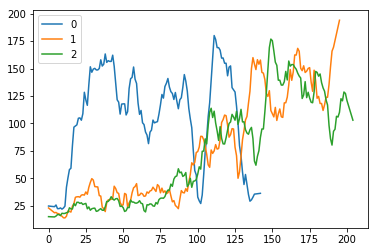

In [46]:
from scipy.signal import savgol_filter
for i in range(3) :
    plt.plot( savgol_filter(agent[i].history["score"] , 9 , 1) , label=i)
    #plt.plot(agent[i].history["score"] , label=i)
plt.legend(loc="best")

In [95]:
state = agent.env.reset()
state.shape

(210, 160, 3)

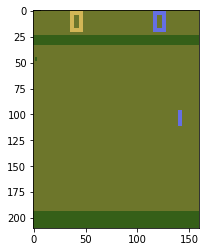

In [96]:
plt.imshow(state)

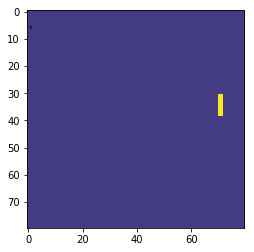

In [103]:
grayState = np.zeros((state.shape[0]//2 , state.shape[1]//2))
for i in range(0,state.shape[0],2) :
    for j in range(0,state.shape[1],2) :
            grayState[i//2,j//2] = float(np.max(state[i:i+2,j:j+2,:])) / 255
grayState = grayState[17:-8,:]
plt.imshow(grayState * 255)

In [106]:
agent.env.close()

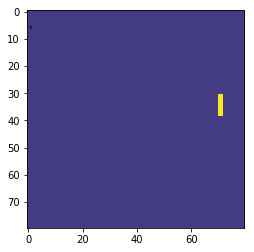

In [109]:
state , _,_,_,_ = agent.memory[0]
plt.imshow(state.reshape(80,80))

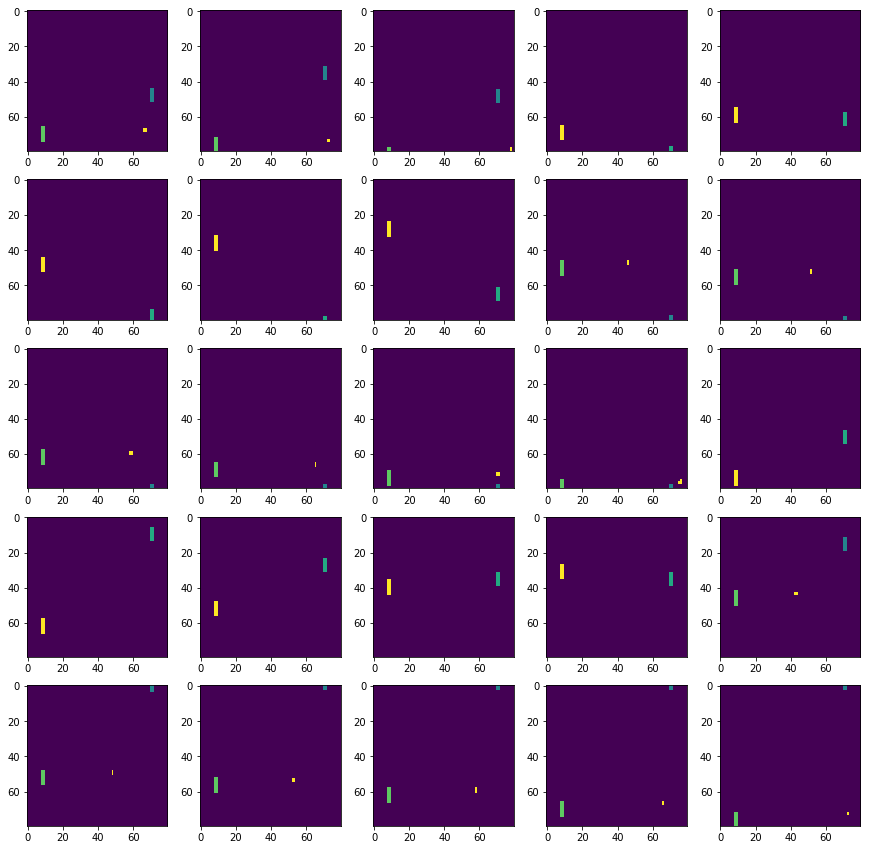

In [110]:
plt.figure(figsize=(15,15))
for i in range(5) :
    for j in range(5) :
        plt.subplot(5,5,5*i+j+1)
        state,_,_,_,_, = agent.memory[100+i*5+j] 
        plt.imshow(state.reshape(80,80))

In [115]:
historyOld = agent.history

In [207]:
state, action, reward, next_state, done =  agent.memory[0]
state

array([[-0.45194285,  0.        ]])

In [208]:
# next_action = 
agent.model.predict(next_state)[0]

array([[-0.01298903,  0.01822895,  0.0157926 ]], dtype=float32)

In [69]:
agentm = [0 for _ in range(3)] 
agentm[0] = AgentMountainCar(DQN)
agentm[0].saveModel()
agentm[1] = AgentMountainCar(NatureDQN)
agentm[2] = AgentMountainCar(DoubleDQN)
for i in range(3) :
    agentm[i].loadModel("./model/DQN-MountainCar.h5")
    agentm[i].epsilon = 1

build model DQN-MountainCar success
save model DQN-MountainCar success.
build model NatureDQN-MountainCar success
build model NatureDQN-MountainCar success
build model DoubleDQN-MountainCar success
build model DoubleDQN-MountainCar success
load model DQN-MountainCar in ./model/DQN-MountainCar.h5 success
load model NatureDQN-MountainCar in ./model/DQN-MountainCar.h5 success
load model DoubleDQN-MountainCar in ./model/DQN-MountainCar.h5 success


In [70]:
agentm[0].play(5 , True)

epoch 0 / 5 played 0.217131405482 scores.
epoch 1 / 5 played 0.333837318062 scores.
epoch 2 / 5 played 0.245684356476 scores.
epoch 3 / 5 played 0.334181323773 scores.
epoch 4 / 5 played 0.230283734477 scores.


In [74]:
%%time
for i in range(3) :
    agentm[i].train(5000)
    agentm[i].saveHistory()
    agentm[i].saveModel()
    print("===============================")

epoch 199 / 5000 played 0.535358200953 scores.
epoch 399 / 5000 played 0.35911385077 scores.
epoch 599 / 5000 played 0.721260221647 scores.
epoch 794 / 5000 played 0.998526943572 scores.
epoch 994 / 5000 played 0.547142541043 scores.
epoch 1194 / 5000 played 0.721260221647 scores.
epoch 1386 / 5000 played 0.998502978229 scores.
epoch 1586 / 5000 played 0.631629274651 scores.
epoch 1786 / 5000 played 0.281275321233 scores.
epoch 1986 / 5000 played 0.721260221647 scores.
epoch 2186 / 5000 played 0.721260221647 scores.
epoch 2376 / 5000 played 0.994934852914 scores.
epoch 2543 / 5000 played 0.994415183914 scores.
epoch 2719 / 5000 played 0.998359051481 scores.
epoch 2864 / 5000 played 0.998058253974 scores.
epoch 3032 / 5000 played 0.99081406347 scores.
epoch 3198 / 5000 played 0.998138485648 scores.
epoch 3354 / 5000 played 0.995182574398 scores.
epoch 3511 / 5000 played 0.989895188547 scores.
epoch 3653 / 5000 played 0.995520562225 scores.
epoch 3819 / 5000 played 0.994732523635 scores.

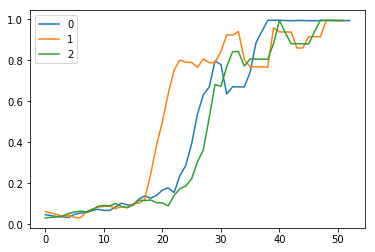

In [81]:
for i in range(3) :
    plt.plot( savgol_filter(agentm[i].history["score"] , 5 , 1) , label=i)
    #plt.plot(agentm[i].history["score"] , label=i)
plt.legend(loc="best")

In [131]:
agent.play(1 , True)

epoch 0 / 1 played -1868 scores.


In [136]:
agent.env.close()

In [ ]:
%%time
agent.train(200000)

epoch 277 / 200000 played -1843 scores.
epoch 559 / 200000 played -1839 scores.
epoch 858 / 200000 played -1723 scores.


In [137]:
agent.saveModel()
agent.saveHistory()

save model NatureDQN-Pong success.
save history in ./history/NatureDQN-Pong.csv
